## Bussiness Problem

The Rossmann Sales Company


A private drug store chain based in Germany, with main operations on Europe. Operates over 3,000 drug stores in 7 different contries.


Offers heathcare and beauty product, including baby and body care, hygiene, cosmetics, dental hygiene, hair care, and so on.


Business Model: Product sales.

The problem:


The CFO (chief financial officer) wanted to reinvest in all stores, therefore, he need to know how much revenue each store will bring so he can invest it now.

Goal:
    

Predict the daily sales of all stores for up to 13 weeks in advance.

In [1]:
import math
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import inflection
import datetime
import warnings
import random
import pickle
import json

import xgboost               as xgb
    
from tabulate                import tabulate
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from boruta                  import BorutaPy

from IPython.core.display    import HTML
from IPython.display         import Image

# Versão da Linguagem Python
from platform                import python_version
print('The current python version running on this Jupyter Notebook is :', python_version())
warnings.filterwarnings( 'ignore' )

The current python version running on this Jupyter Notebook is : 3.9.7


In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7) #primeiro dia da primeira semanada da venda realizada
        end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7) #ultimo dia 

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_sales_raw = pd.read_csv('train-2.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [7]:
df_raw.shape

(1017209, 18)

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [9]:
df_raw.describe(include=np.number)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [10]:
df_raw.describe(include=np.object)

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,4,4,3,3
top,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,986159,551627,537445,293122


In [11]:
df1 = df_raw.copy()

In [12]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df1.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [14]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

#Rename Columns

df1.columns = cols_new

In [15]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

Id - an Id that represents a (Store, Date) duple within the test set


Store - a unique Id for each store


Sales - the turnover for any given day (this is what you are predicting)


Customers - the number of customers on a given day


Open - an indicator for whether the store was open: 0 = closed, 1 = open


StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools


StoreType - differentiates between 4 different store models: a, b, c, d


Assortment - describes an assortment level: a = basic, b = extra, c = extended


CompetitionDistance - distance in meters to the nearest competitor store


CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened


Promo - indicates whether a store is running a promo on that day


Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2


PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


In [17]:
df1['date'] = pd.to_datetime( df1[ 'date' ] )
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [18]:
missing_count = df1.isnull().sum() 
value_count = df1.isnull().count() 

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.00
day_of_week,0,0.00
date,0,0.00
sales,0,0.00
customers,0,0.00
open,0,0.00
promo,0,0.00
state_holiday,0,0.00
school_holiday,0,0.00
store_type,0,0.00


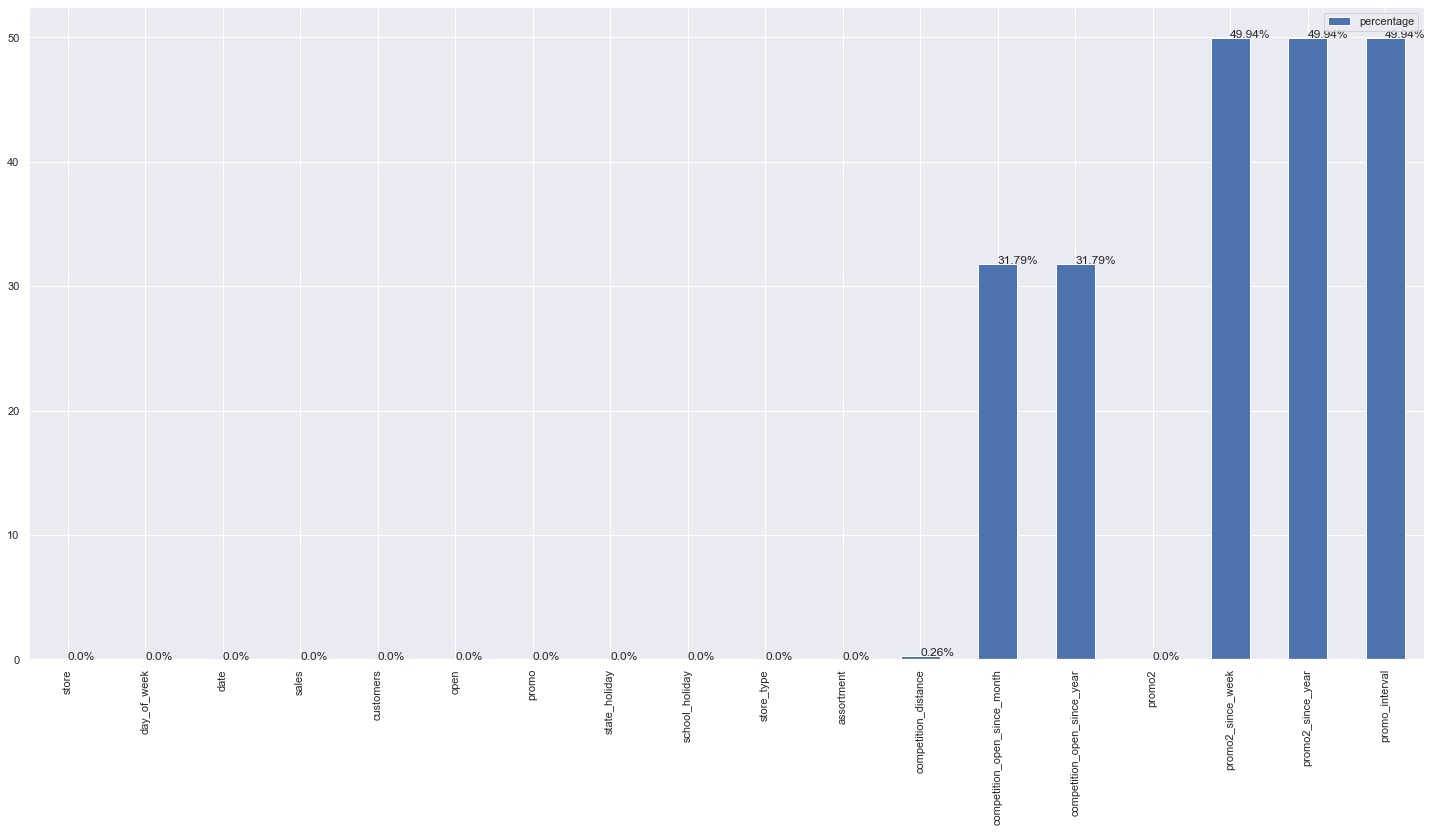

In [19]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [20]:
# assumptions:
# competitions distance (replace with the median distance)
# competition open since month and year, it's an important feature, so lets replace the nan with the date of the sale data

In [21]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2330.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],
                                               axis = 1 )
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'],
                                               axis = 1 )
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'],
                                               axis = 1 )
# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'],
                                               axis = 1 )
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [22]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
df1 = df1.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64', 'promo2_since_week':'int64', 'promo2_since_year':'int64' })

In [25]:
df1.dtypes # checking datatypes transformation

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5422.033790,7706.913044,20.0,710.0,2330.0,6880.0,75860.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [27]:
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

In [28]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5422.033790,2330.0,7706.909256,2.933466,13.040563
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [29]:
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

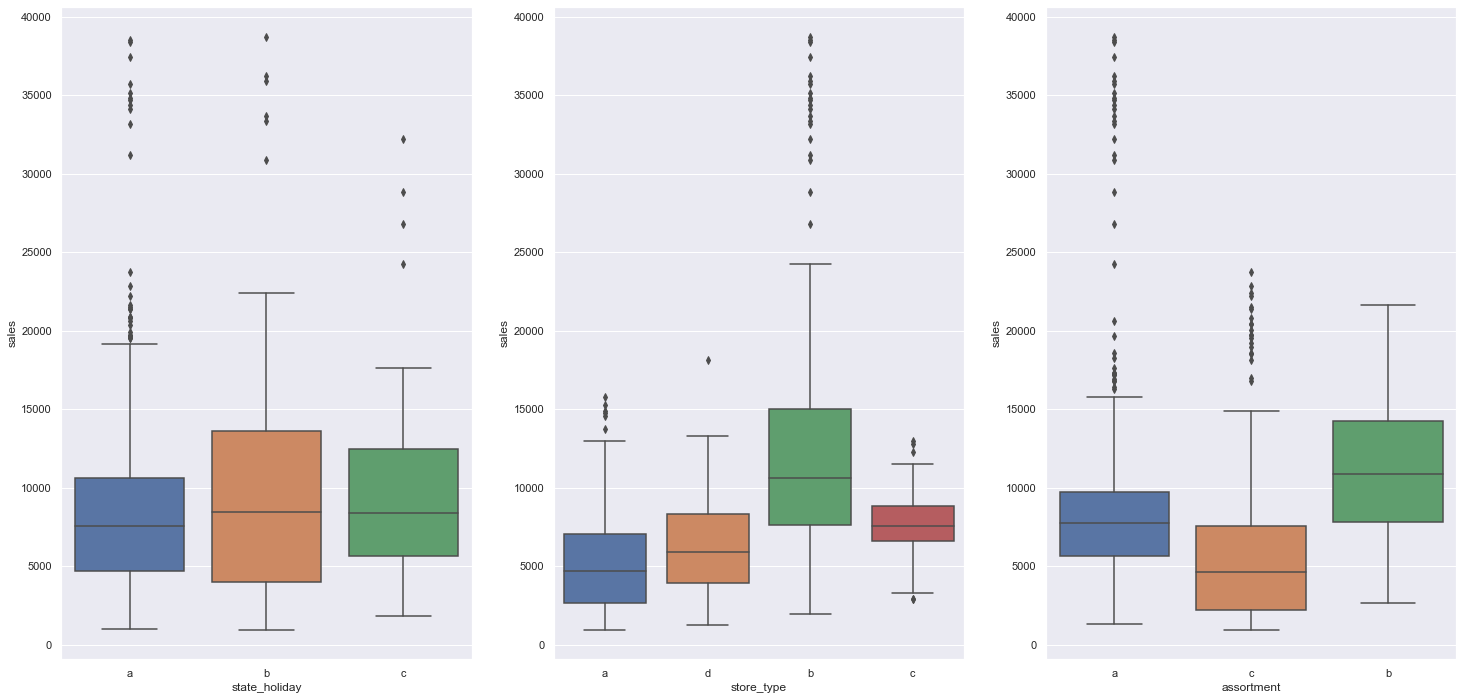

In [30]:
# plot boxplots of categorical features against target variable
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data=aux1);

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data=aux1);

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data=aux1);

***Hypothesis for Stores***

Stores with more employees should sell more.


Stores with greater inventory capacity should sell more.


Larger stores should sell more.


Stores with larger assortments should sell more.


Stores with closer competitors should sell less.


Stores with longer competitors should sell more

***Product Hypothesis***

Stores that invest more in Marketing should sell more.


Stores with more product exposure should sell more.


Stores with lower priced products should sell more.


Stores with more aggressive promotions (having big discounts) should sell more.


Stores with longer running promotions should sell more.


Stores with more promotion days should sell more.


Stores with more consecutive promotions should sell more.



***Time Hypothesis***

Stores open during Christmas holiday should sell more.


Stores should sell more over the years.


Stores should sell more during the second half of the year.


Stores should sell more after the 10th day of each month.


Stores should sell less on weekends.


Stores should sell less during school holidays.

***Final Hypothesis list***

###### We will consider the promotions based on the available attributes in the dataset.

1.Stores with larger assortments should sell more.


2.Stores with closer Competition/Competitiors should sell less.


3.Stores with far away Competition/Competitiors should sell more.


4.Stores with longer running promotions should sell more.


5.Stores with more promotion days should sell more.


6.Stores with more consecutive promotions should sell more.


7.Stores open during Christmas holiday should sell more.


8.Stores should sell more over the years.


9.Stores should sell more during the second half of the year.


10.Stores should sell more after the 10th day of each month.


11.Stores should sell less on weekends.


12.Stores should sell less during school holidays.

In [31]:
df2 = df1.copy()

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [33]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [35]:
df3 = df2.copy()

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales']> 0)]
### I have to check df3['open'] != 0 & df3[sales] = 0
# open stores that did not sell in that day
#I don't have the column customers during the forecast, it's a business constraint

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [38]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [39]:
df4 = df3.copy()

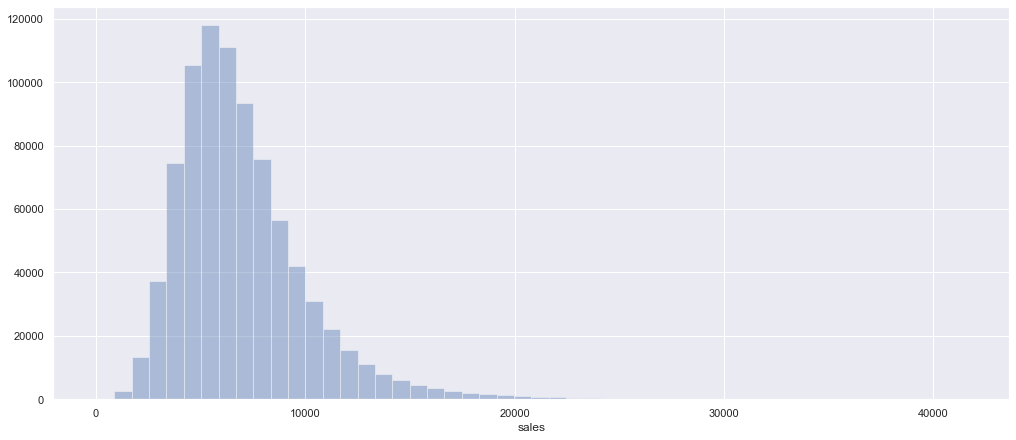

In [40]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['sales'], kde = False);

Very close to a normally distribution behaviour, yet it's not completely normally distributed.



The more normally distributed the target variable is, the better the algorithm will perform.

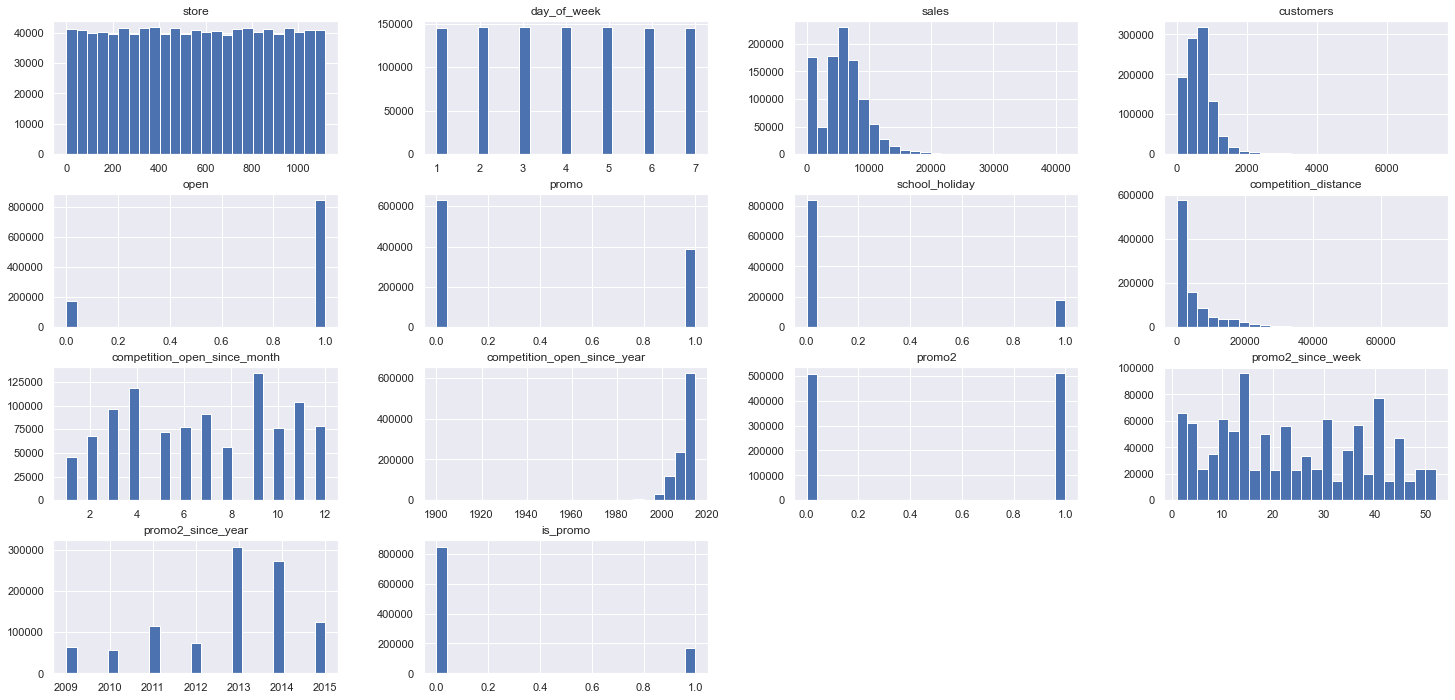

In [41]:
num_attributes.hist(bins = 25);

In [42]:
# Verify this properly

Overall: All variables don't follow a normal distribution
- day: There are specific days which has almost double sales data points than others (day)
- month: More sales data points on the first semester
- year: Less data points in 2015 (compared to other years)
- customers: Resemble a poisson distribution.
- week_of_year: A boom of sales data points during the first weeks of the year
- day_of_week: less sales data points on sundays
- is_weekday: more sales data points on weekdays
- school_holiday: more sales data points on regular days
- competition_distance: more sales data points for stores with closer competitors
- competition_open_since_month: more sales data points for competitors which entered competition on April, July, September
- competition_since_month: no relevant info retrieved
- is_promo2: more sales data points for 0
- competition_open_since_year, promo2, promo, promo_since, promo_time: no relevant info retrieved

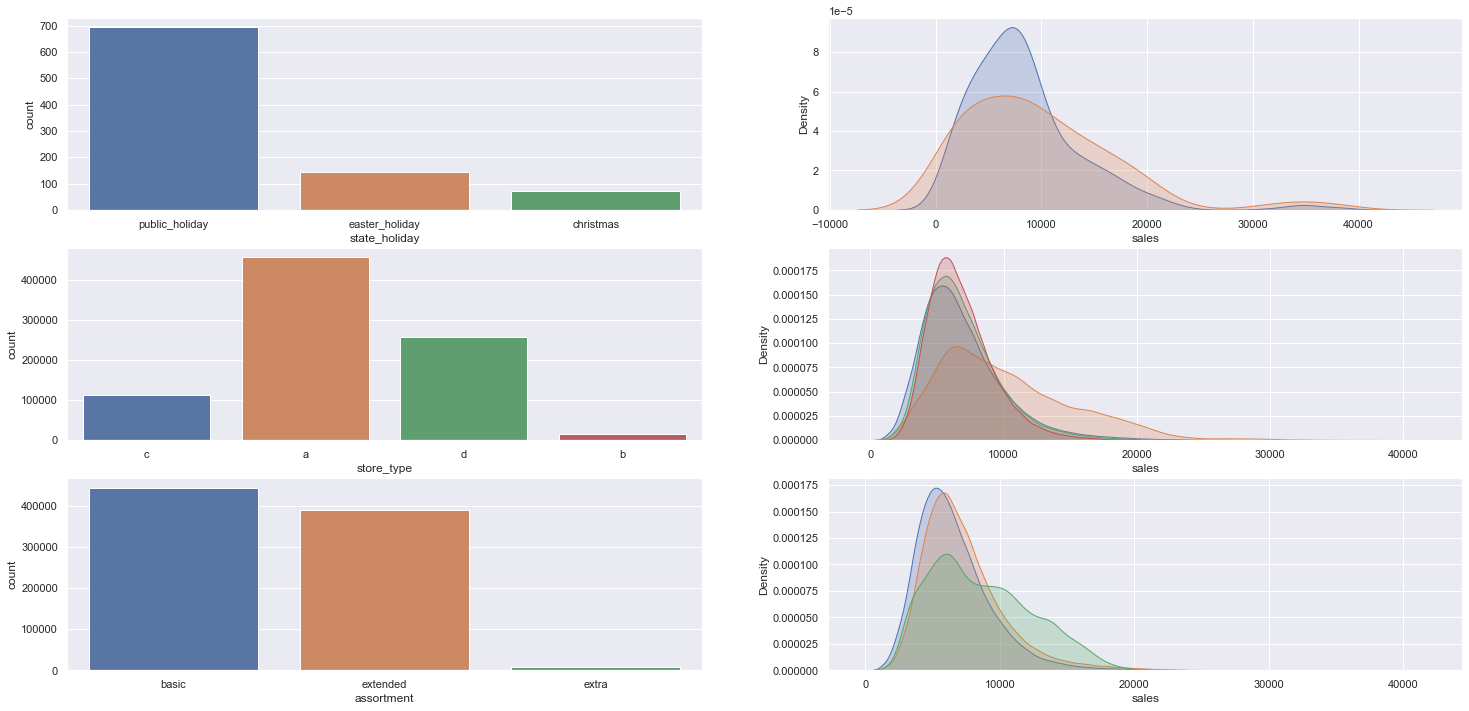

In [43]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True )
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data = df4, x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'a']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'b']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'c']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'd']['sales'], shade = True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(data = df4, x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'basic']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extended']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extra']['sales'], shade = True);

#### Let's verify if our final Hypothesis is true or false

***H1. Stores with extended assortment type sell more.***

***FALSE*** Stores with bigger assortment sell less. However, the number of data points for stores with assortment 'extra' is very low compared to the other two. Since assortment 'extra' follows a similar sales pattern of the other two, assortment might not be meaningful on our model.

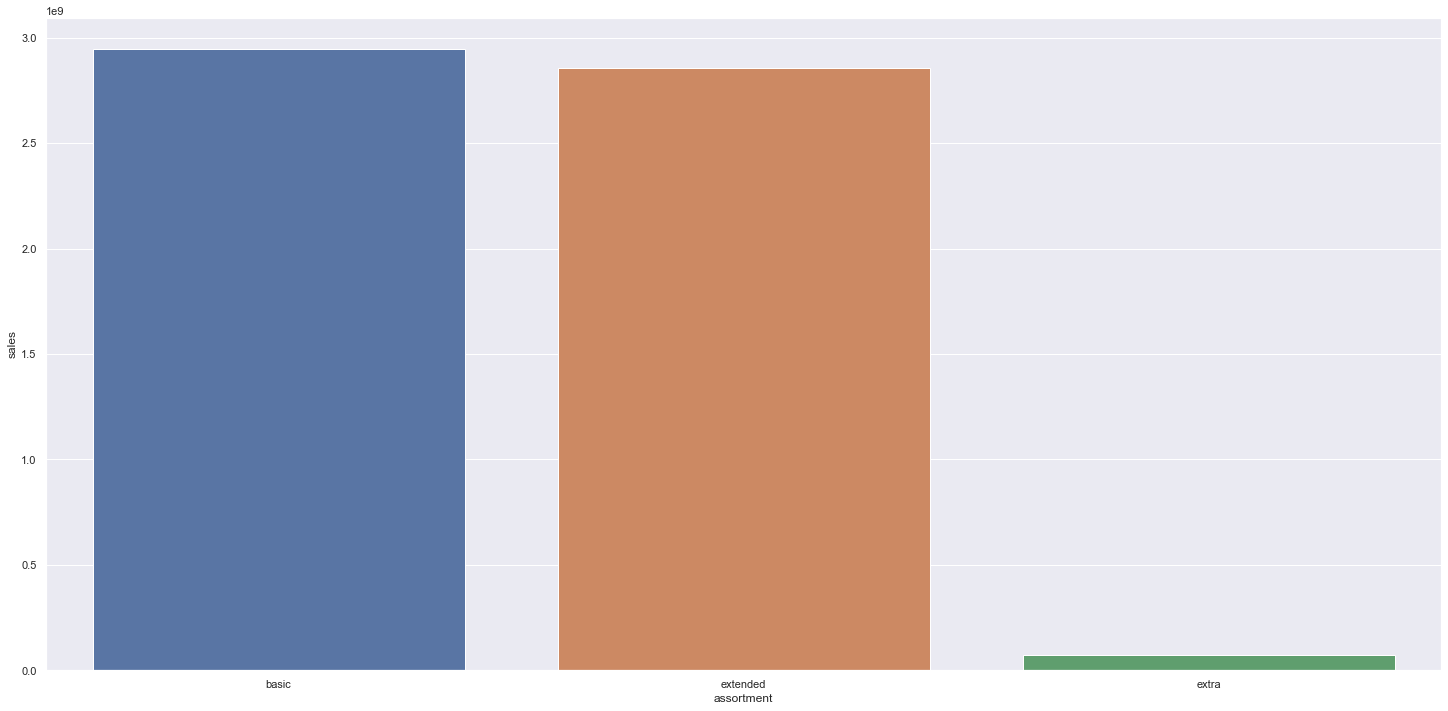

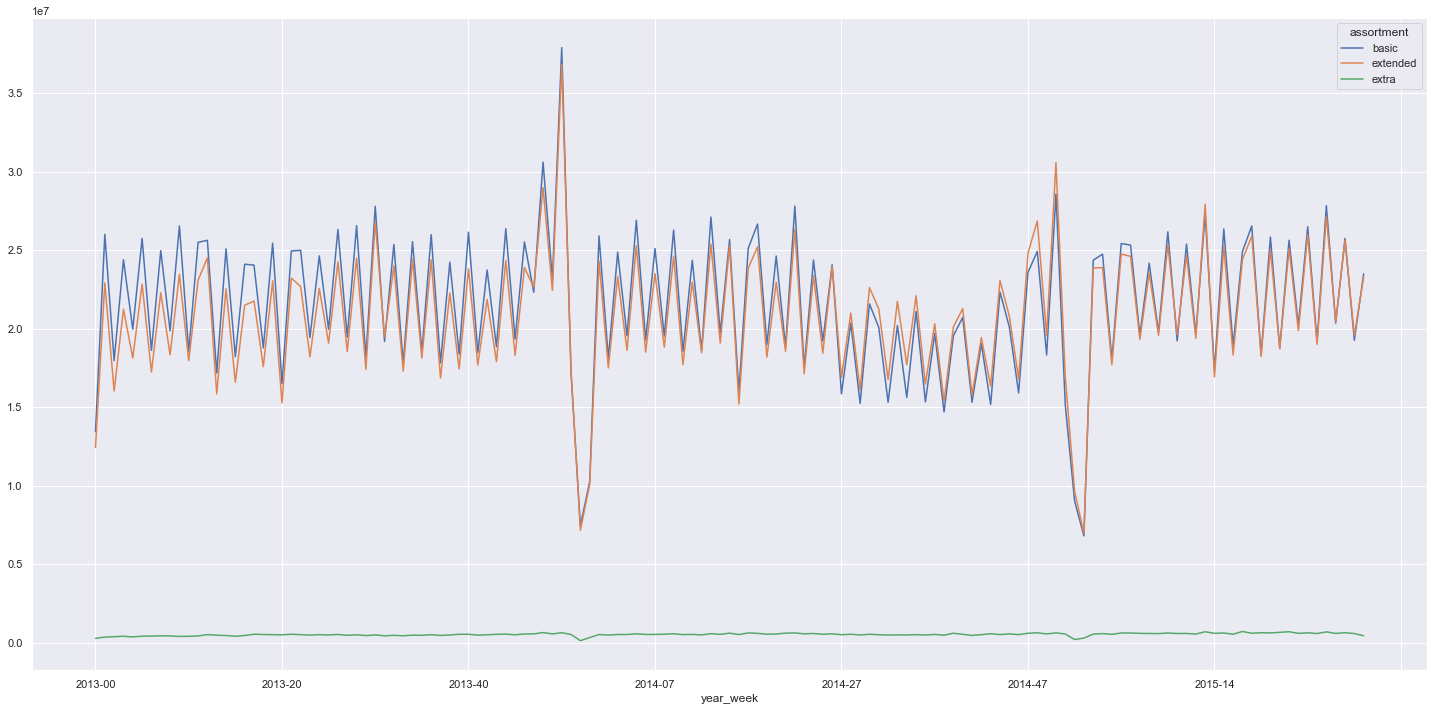

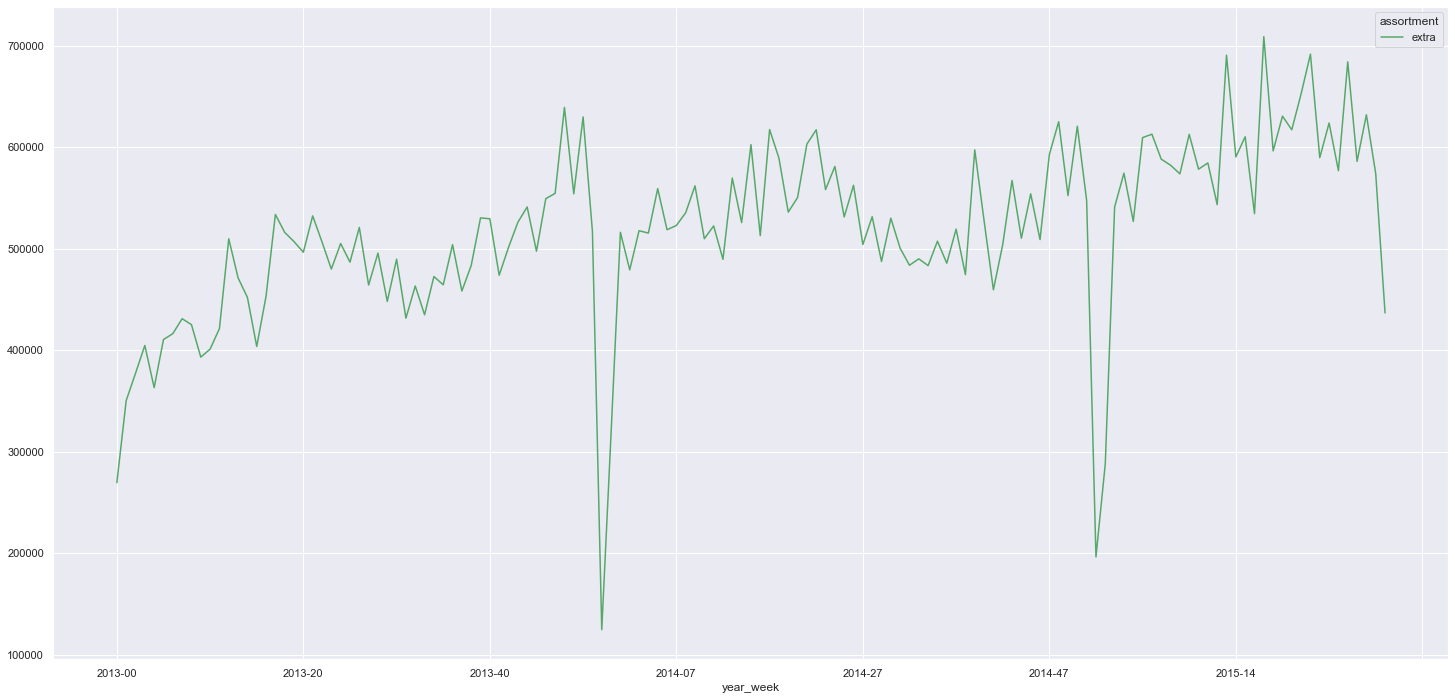

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot( color = 'g' );

***H2. Stores with near competitors sell less.***

***FALSE*** Stores with near competitors sell more.

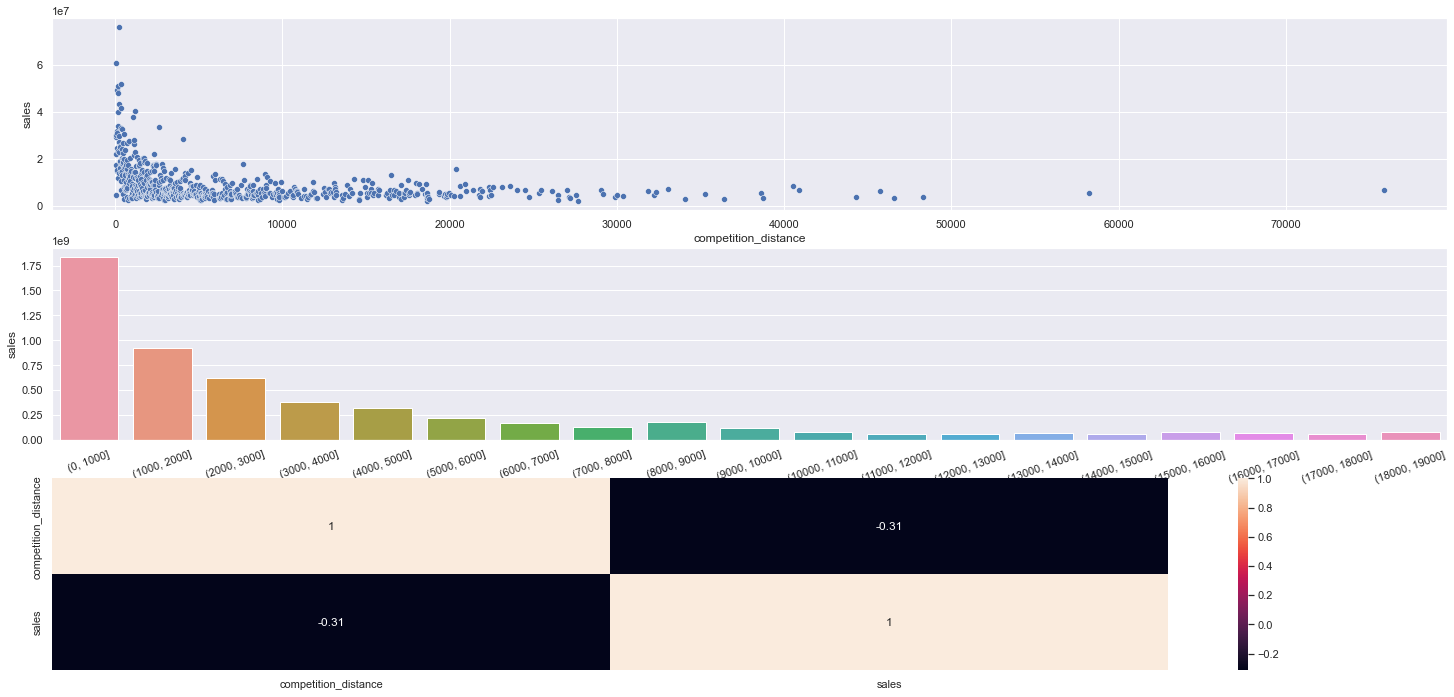

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3, 1, 1)
sns.scatterplot(x= 'competition_distance', y= 'sales', data= aux1);

plt.subplot(3, 1, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation = 20)
sns.barplot( x= 'competition_distance_binned', y= 'sales', data = aux2);



plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

***H3. Stores with longer competitors should sell more.***

***FALSE*** Stores with longer competitors sell less!.

<AxesSubplot:>

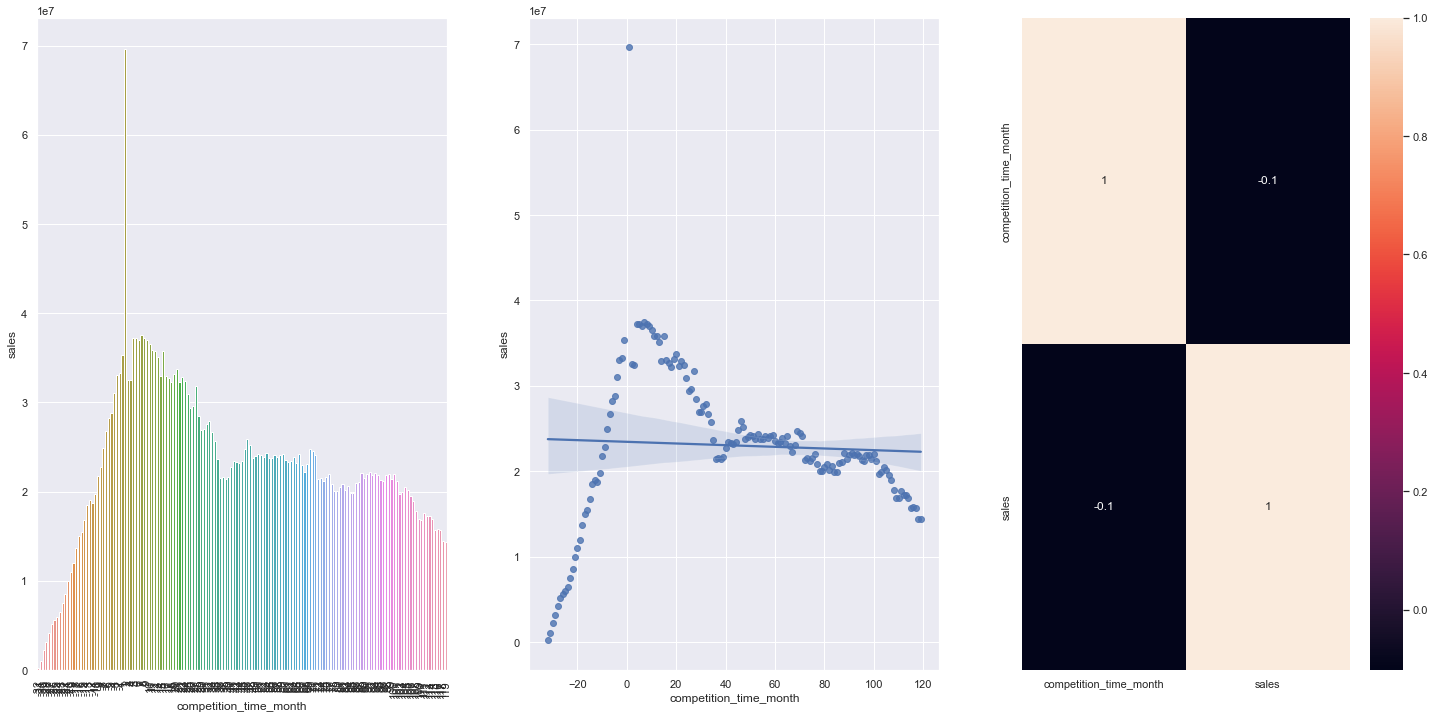

In [46]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x= 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

***H4. Stores with longer active promo should sell more***

***FALSE***, Stores with longer active promotions sell less after a certain promotion period.

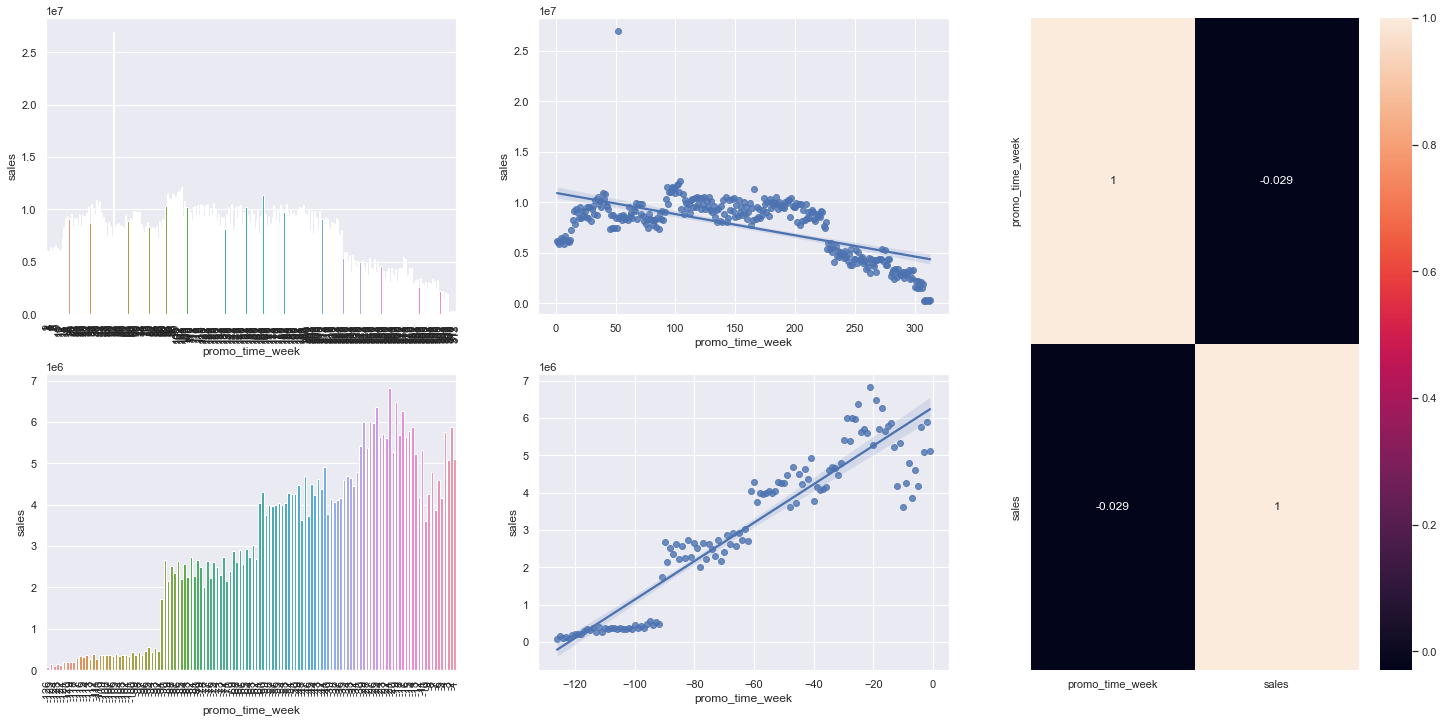

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(data = aux2, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation= 90);

plt.subplot(grid[0,1])
sns.regplot(data = aux2, x= 'promo_time_week', y= 'sales')

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(data = aux3, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation= 90);

plt.subplot(grid[1,1])
sns.regplot(data = aux3, x= 'promo_time_week', y= 'sales');

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method = 'pearson'), annot= True);

***H6. Stores with more consecutive promotions should sell more.***

***FALSE*** ,Stores with more consecutive promotions SELL LESS!

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending = True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


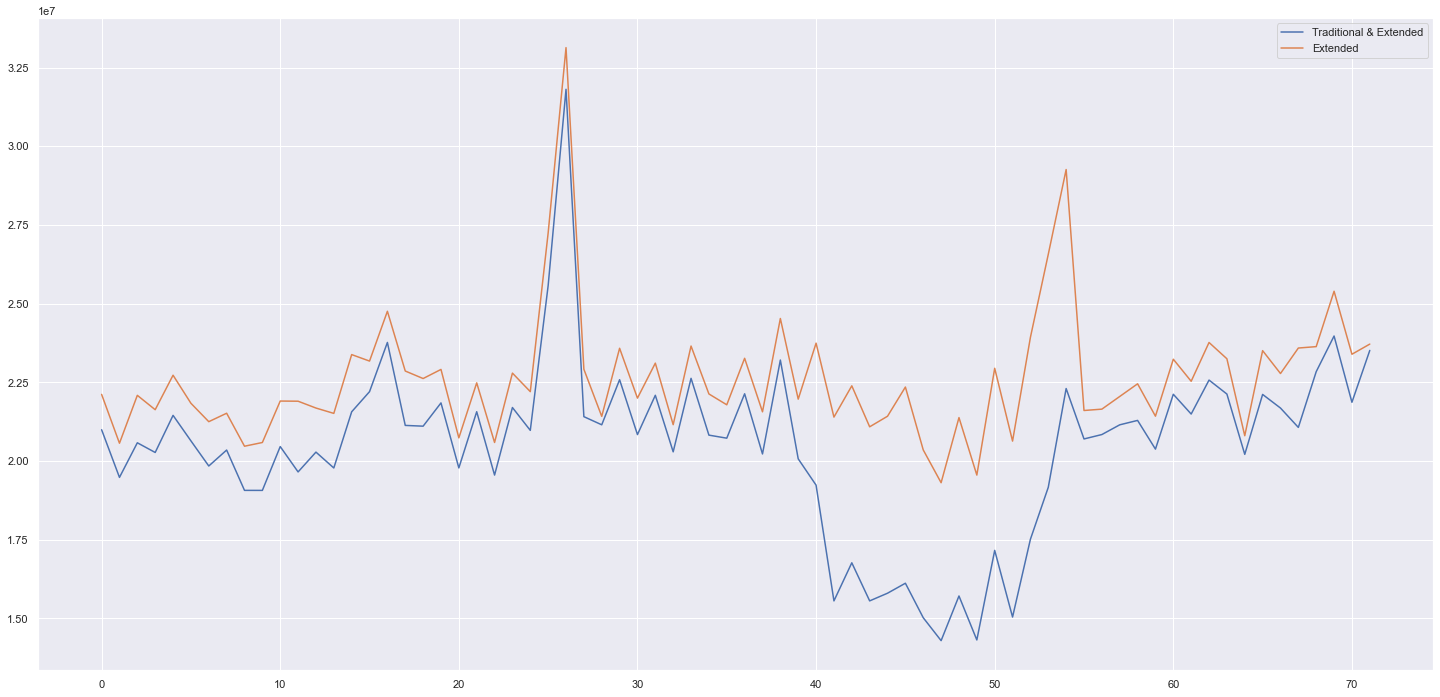

In [49]:
aux1 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Traditional & Extended', 'Extended']);

***H7. Stores open during the Christmas holiday should sell more.***

***FALSE*** Stores open during the Christmas holiday no longer sell.

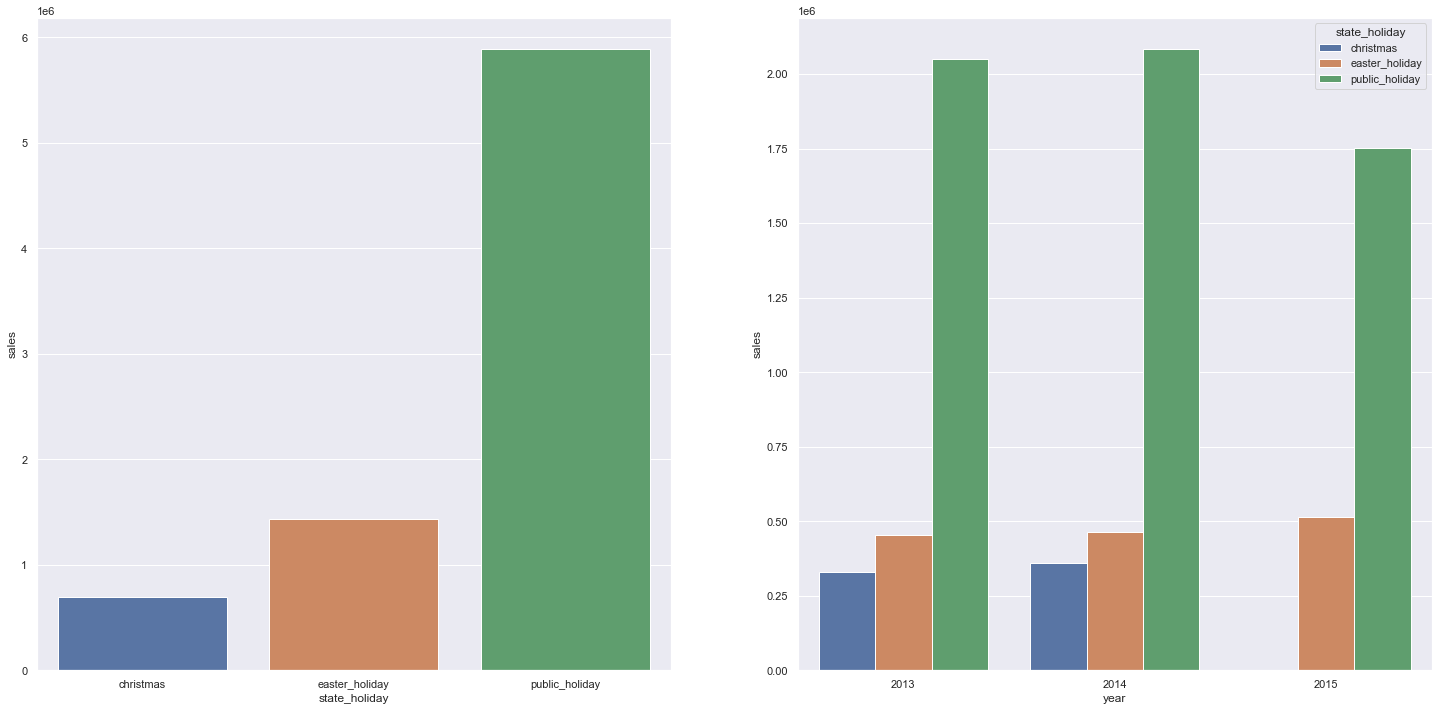

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux1, x= 'state_holiday', y= 'sales');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data = aux2, x = 'year', y= 'sales', hue= 'state_holiday');


***H8. Stores should sell more over the years.***

***FALSE***, Stores sell less over the years

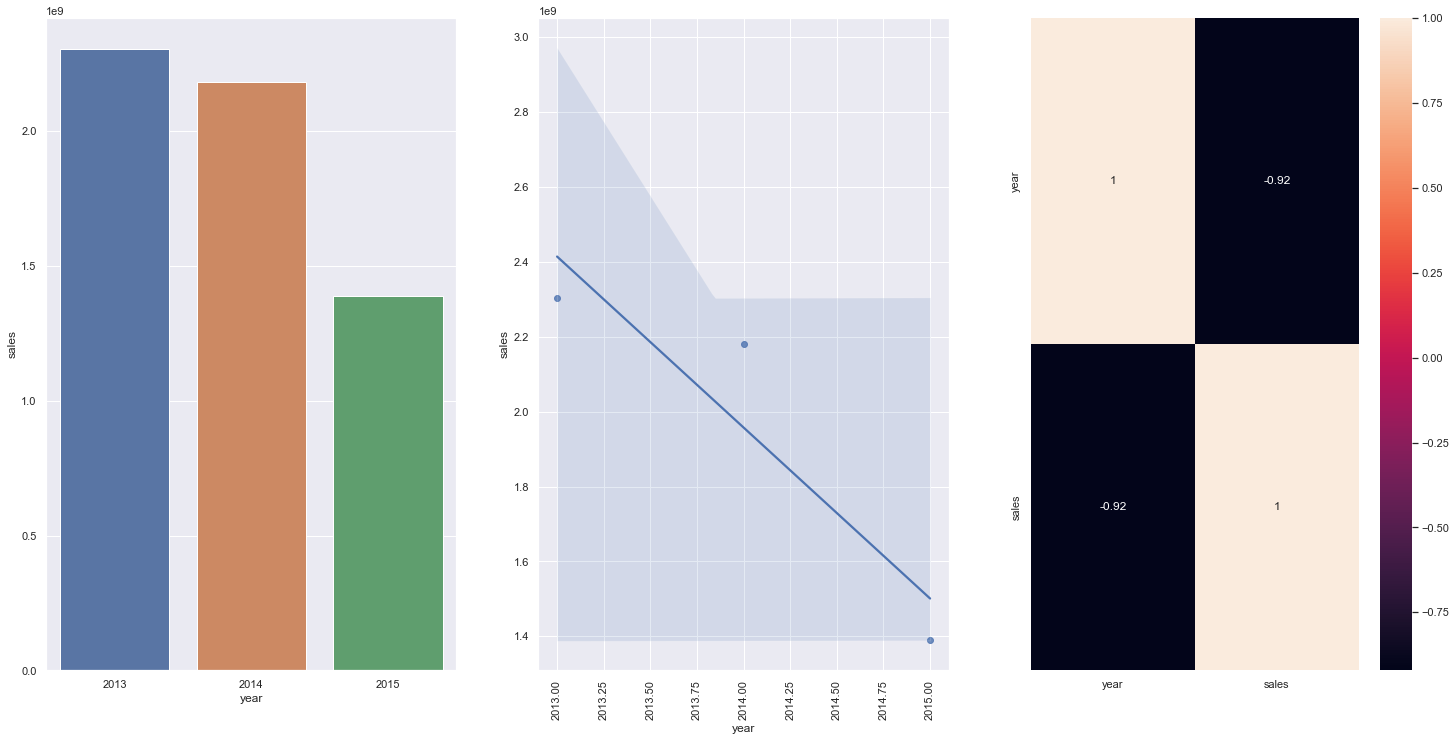

In [51]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'year', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'year', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

***H9. Stores should sell more in the second half of the year.***

***FALSE***, Stores sell less in the second half of the year

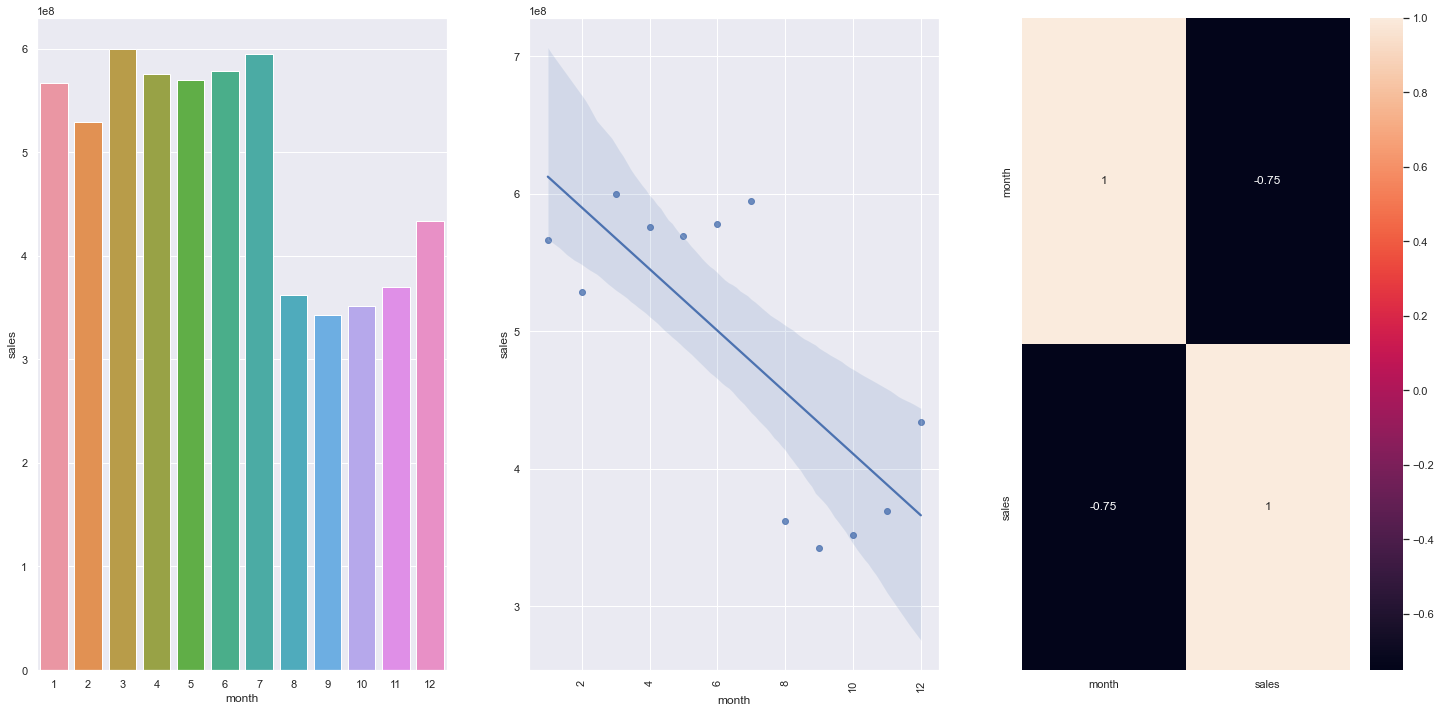

In [52]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'month', y= 'sales');   

plt.subplot(132)
sns.regplot(data = aux, x= 'month', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

***H10. Stores should sell more after the 10th of each month.***

***TRUE***, Stores sell more after the 10th.

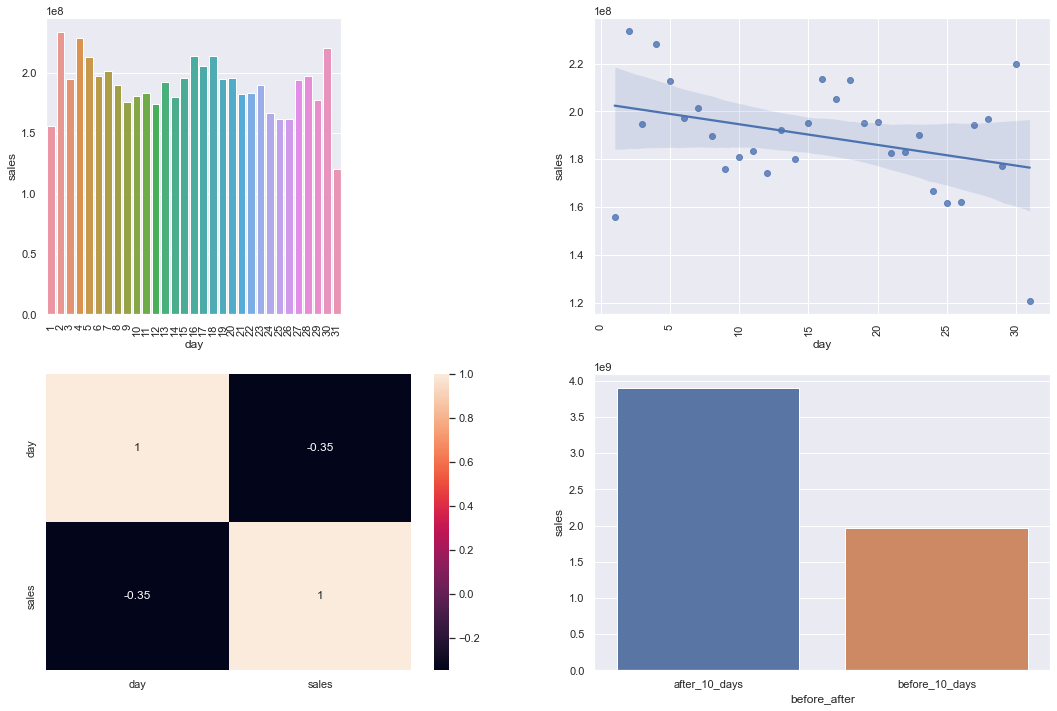

In [53]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

fig = plt.figure(figsize = (18,12))
plt.subplot(231)
sns.barplot(data = aux, x= 'day', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(222)
sns.regplot(data = aux, x= 'day', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(223)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else
                                                  'after_10_days')

aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(224)
sns.barplot(data = aux1, x= 'before_after', y= 'sales');

***H11. Stores should sell less on weekends.***

***TRUE*** stores sell less on weekends!

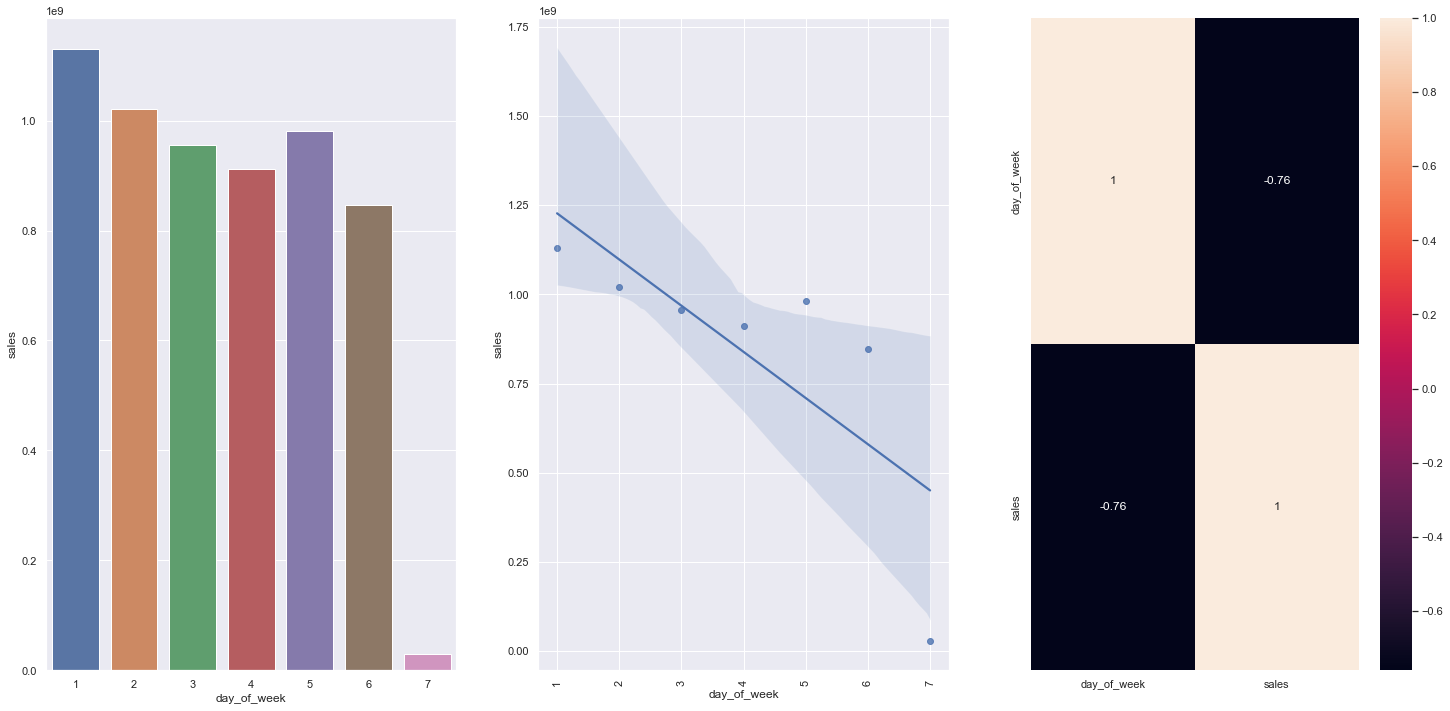

In [54]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'day_of_week', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'day_of_week', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

***H12. Stores should sell less during school holidays***

***TRUE*** stores sell less during school holidays. Except in August they sell more

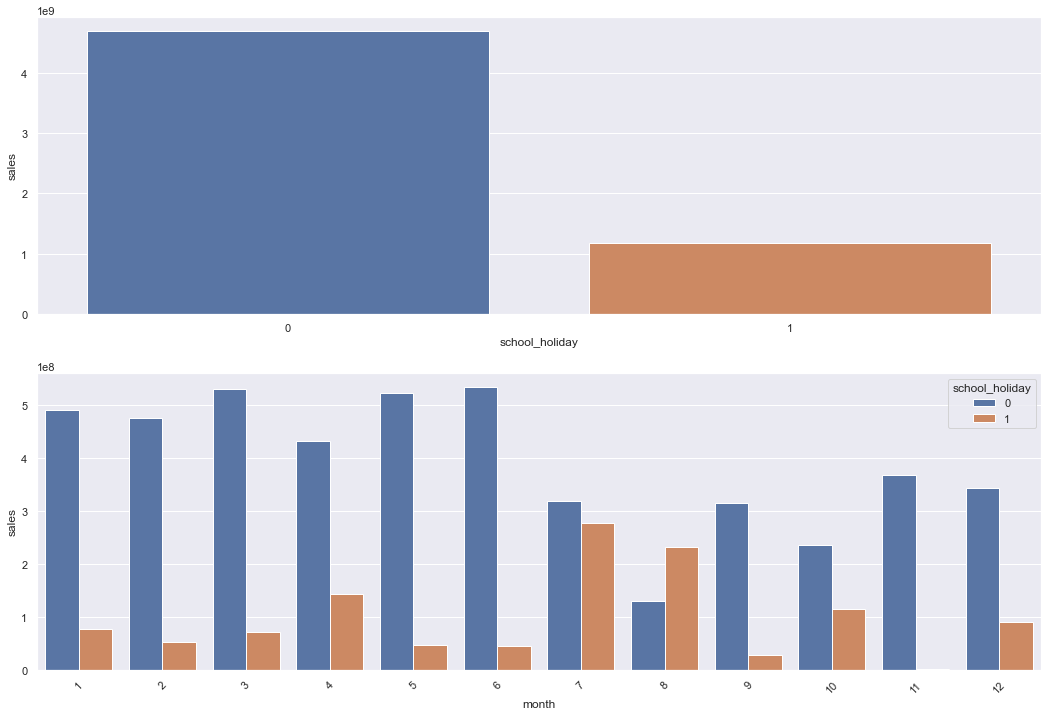

In [55]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index();

fig = plt.figure(figsize = (18,12))
plt.subplot(211)
sns.barplot(data = aux, x= 'school_holiday', y= 'sales');

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index();

plt.subplot(212)
sns.barplot(data = aux2, x= 'month', y= 'sales', hue= 'school_holiday');
plt.xticks(rotation = 45);

In [56]:
summary = pd.DataFrame({'Hypothesis':['Stores with extended assortment type sell more.',
                                      'Stores with near competitors sell less.',
                                      'Stores with longer competitors should sell more.',
                                      'Stores with longer active promo should sell more.',
                                      'Stores with more promotion days should sell more.',
                                      'Stores with more consecutive promotions should sell more.',
                                      'Stores open during the Christmas holiday should sell more.',
                                      'Stores should sell more over the years.',
                                      'Stores should sell more in the second half of the year.',
                                      'Stores should sell more after the 10th of each month.',
                                      'Stores should sell less on weekends.',
                                      'Stores should sell less during school holidays.',
                                     ],
                        'True / False':['False', 'False', 'False', 'False', '-', 'False', 'False', 'False', 'False',
                                        'True','True', 'True'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', '-', 'Low', 'Medium', 'High', 'High', 
                                     'High', 'High', 'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

,Hypothesis,True / False,Relevance
1,Stores with extended assortment type sell more.,False,Low
2,Stores with near competitors sell less.,False,Medium
3,Stores with longer competitors should sell more.,False,Medium
4,Stores with longer active promo should sell more.,False,Low
5,Stores with more promotion days should sell more.,-,-
6,Stores with more consecutive promotions should...,False,Low
7,Stores open during the Christmas holiday shoul...,False,Medium
8,Stores should sell more over the years.,False,High
9,Stores should sell more in the second half of ...,False,High
10,Stores should sell more after the 10th of each...,True,High


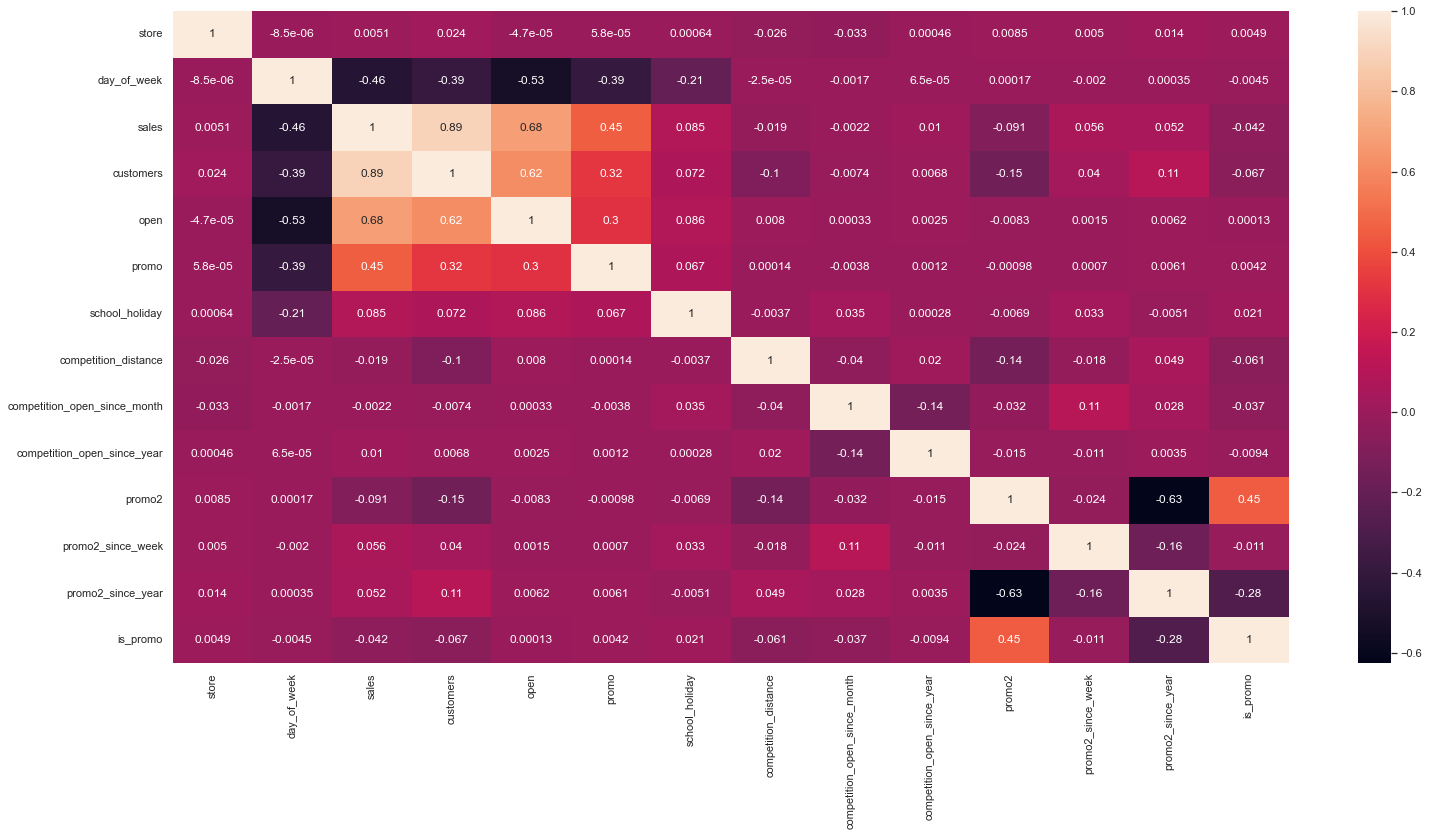

In [57]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );


In [58]:
a = df4.select_dtypes( include = 'object')

# Calculate and create a cramer matrix

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index( d.columns) # Setting index name equal to the columns names
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


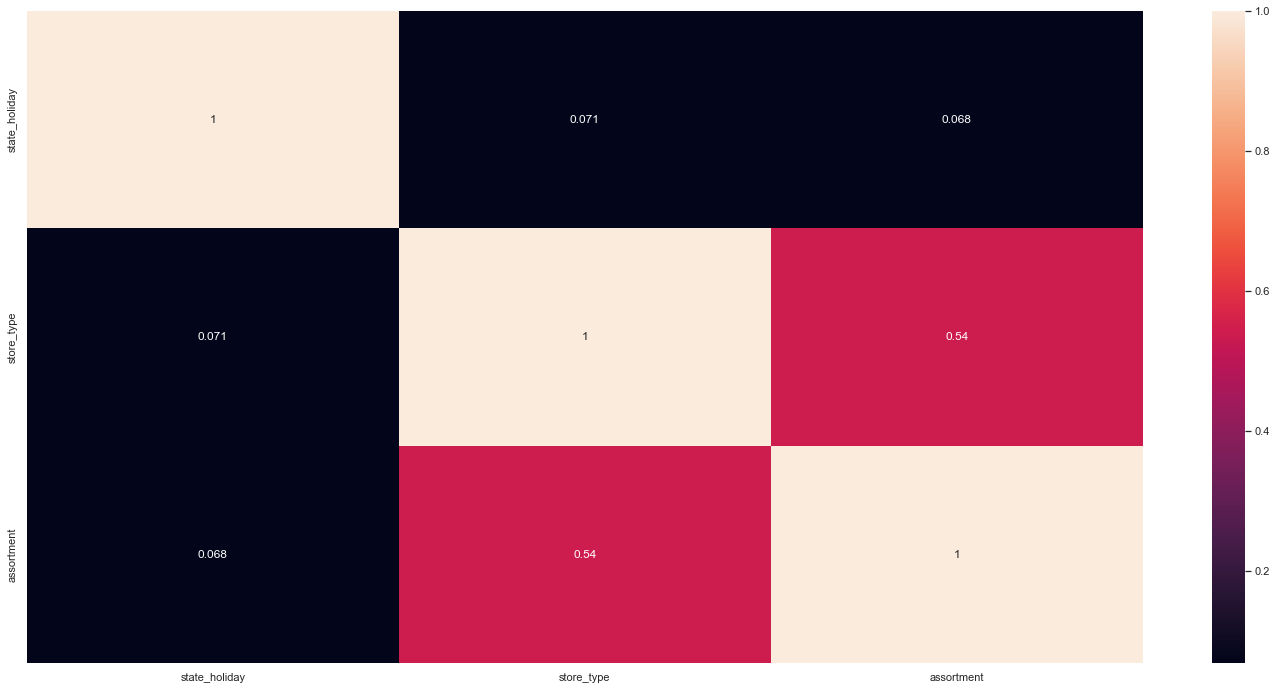

In [59]:
sns.heatmap(d, annot = True);

In [60]:
df5 = df4.copy()
df6=df4.copy()

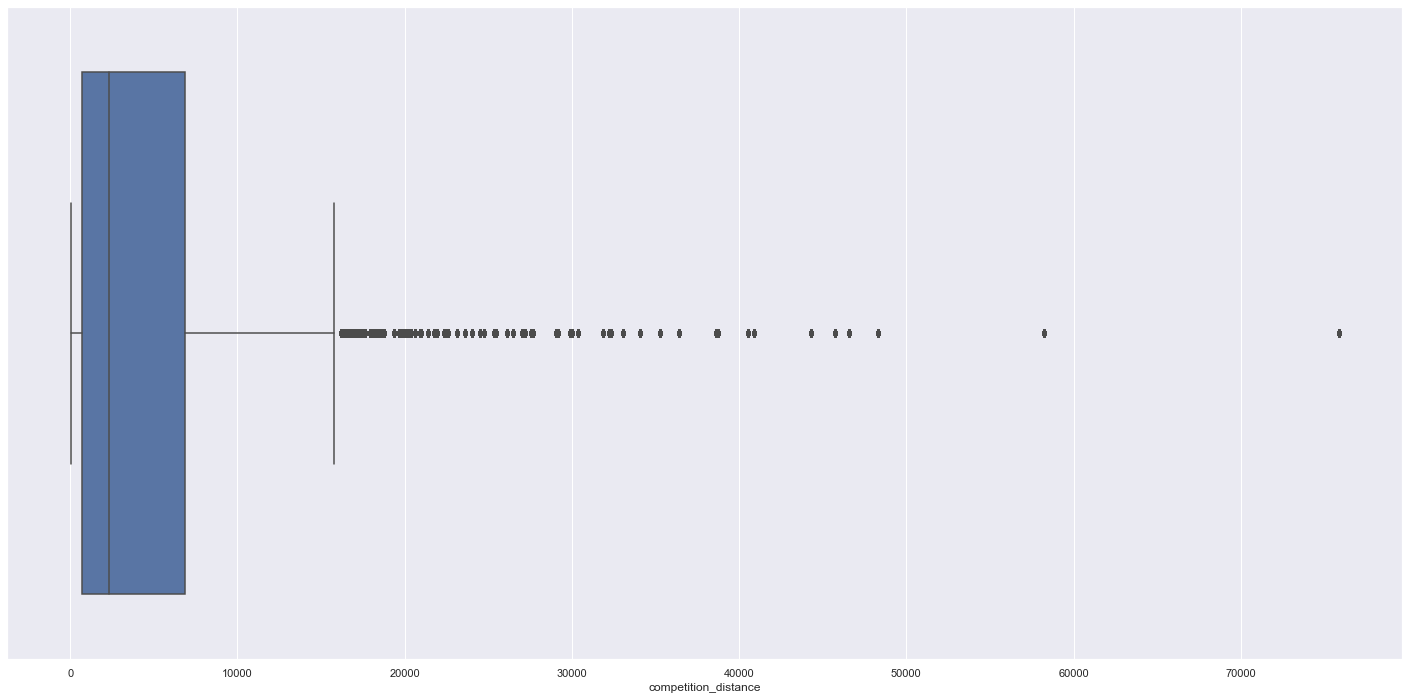

In [61]:
# boxplot to check outliers sensitivity
sns.boxplot(x = df5['competition_distance']);

In [62]:
rs = RobustScaler()  #selecting this method due to outliers
                     #same formula as minmax scaler, however it uses interquantile intervals as range and it's robust to outliers.
mms = MinMaxScaler() #super sensitive to outliers

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values ) 


# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


# year
df5['year'] = mms.fit_transform( df5[['year']].values )


In [63]:
df5.select_dtypes( include = 'object').head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [64]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [65]:
# state_holiday (it's a state, holidays are moments) - One Hot Enconding
df5 = pd.get_dummies(df4, prefix = ['state_holiday'], columns = ['state_holiday'], dtype = 'int64' )

# store_type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )


# assortment - Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

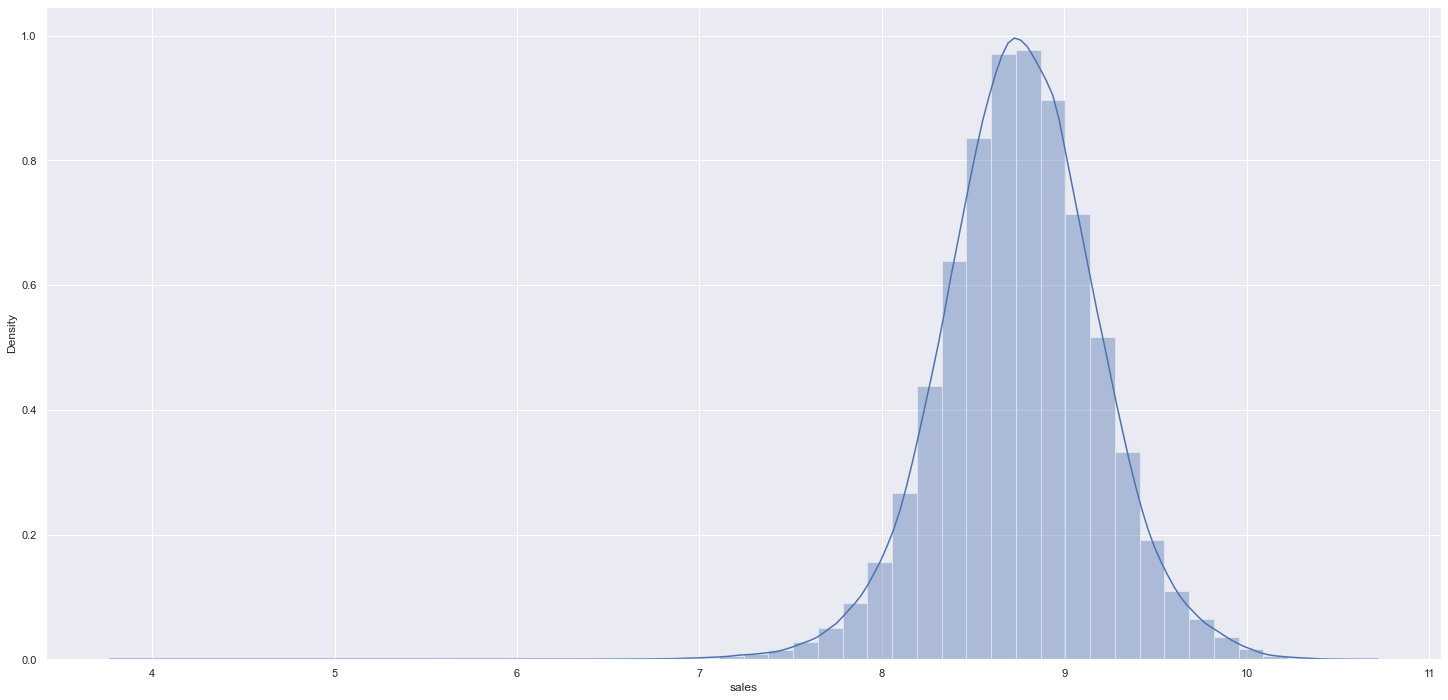

In [66]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales']);

***The log transformation is, arguably, the most popular among the different types of transformations used to transform skewed data to approximately conform to normality.***

consider adding the (sine, cosine) transformation of the time of day variable? This will ensure that the 0 and 23 hour for example are close to each other, thus allowing the cyclical nature of the variable to shine through.

In [67]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [68]:
df5 = df5.astype({'store_type': 'int64'})
df5.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

In [69]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int64         
 1   day_of_week                   844338 non-null  int64         
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  float64       
 4   promo                         844338 non-null  int64         
 5   school_holiday                844338 non-null  int64         
 6   store_type                    844338 non-null  int64         
 7   assortment                    844338 non-null  int64         
 8   competition_distance          844338 non-null  float64       
 9   competition_open_since_month  844338 non-null  int64         
 10  competition_open_since_year   844338 non-null  int64         
 11  promo2      

In [70]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [71]:
df7 = df5.copy()

selecting the most relevant features that describes our dataset (phenomenon). removing collinear features, its explain the same part of the phenomenon.

always prefer the simplest model.

In [72]:
b=df7[df7['store']==931]

In [73]:
# deleting features after feature engineering derivation. Deleting original variables.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
b = b.drop(cols_drop, axis = 1)

In [74]:
# Spliting dataframe into training and test. 
# Test will have the last 13 weeks of sales (i want to predict the next 13 weeks, and because of using time series i can make a random selection)
# starting at 2015-05-01 until the last day of sales

b[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 13*7 )

Timestamp('2015-05-01 00:00:00')

In [75]:
# training dataset
X_train = b[b['date'] < '2015-05-01']
y_train = X_train['sales']

# test dataset
X_test = b[b['date'] >= '2015-05-01']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-02 00:00:00
Training Max Date: 2015-04-30 00:00:00

Test Min Date: 2015-05-02 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [76]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [77]:
pd.DataFrame(data = cols_selected_boruta, columns = ['feature_selected'])

,feature_selected
0,store
1,promo
2,store_type
3,assortment
4,competition_distance
5,competition_open_since_month
6,competition_open_since_year
7,promo2
8,promo2_since_week
9,promo2_since_year


In [78]:
type(cols_selected_boruta_full)

list

In [79]:
x_train = X_train[ cols_selected_boruta ] #selecting only the columns selected by boruta
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [80]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how= 'left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1031.869812,NaN,1300.610672


***Linear Regression Model***

In [81]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction 
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,757.877314,0.216113,964.190222


In [82]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,771.586979,0.21945,987.370848


In [83]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1, random_state=7 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,461.357371,0.128974,613.660831


In [84]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators = 100,
                              eta = 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytree = 0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,3853.240554,0.944961,4055.794152


In [85]:
results = pd.concat( [lr_result, lrr_result, rf_result, xgb_result] )
results.sort_values('MAPE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,461.357371,0.128974,613.660831
0,Linear Regression,757.877314,0.216113,964.190222
0,Linear Regression - Lasso,771.586979,0.219450,987.370848
0,XGBoost Regressor,3853.240554,0.944961,4055.794152


In [86]:
#hypertuning

In [87]:
param_tuned = {
    'n_estimators':1700 ,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7 ,
    'min_child_weight': 15
        }

In [88]:
# model
model_xgb_tuned = xgb.XGBRegressor(  objective='reg:squarederror',
                                      n_estimators = param_tuned['n_estimators'],
                                      eta = param_tuned['eta'],
                                      max_depth = param_tuned['max_depth'],
                                      subsample = param_tuned['subsample'],
                                      colsample_bytree = param_tuned['colsample_bytree'],
                                      min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_tuned_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb_tuned))
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,455.450979,0.129913,613.044437


In [89]:
# It's good to target overestimated sales in business, hence we make use of mpe(mean percentage error)

In [90]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.0008310815236304367

In [91]:
# selecting test dataframe to evaluate error 
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

In [92]:
# sum of prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenerios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [93]:
# worst and best scenarios
df92.sort_values('MAE', ascending = True).head().style.format({'predictions': '{0:,.2f}', 'worst_scenario': '{:,.2f}',  'best_scenario': '{0:,.2f}', 'MAE': '{0:,.2f}', 'MAPE': '{:.2%}'})

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,931,"359,376.22","358,920.77","359,831.67",455.45,12.99%


In [94]:
# worst and best scenarios
df92.sort_values('MAPE', ascending = False).head(10).style.format({'predictions': '{0:,.2f}', 'worst_scenario': '{:,.2f}',  'best_scenario': '{0:,.2f}', 'MAE': '{0:,.2f}', 'MAPE': '{:.2%}'})

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,931,"359,376.22","358,920.77","359,831.67",455.45,12.99%


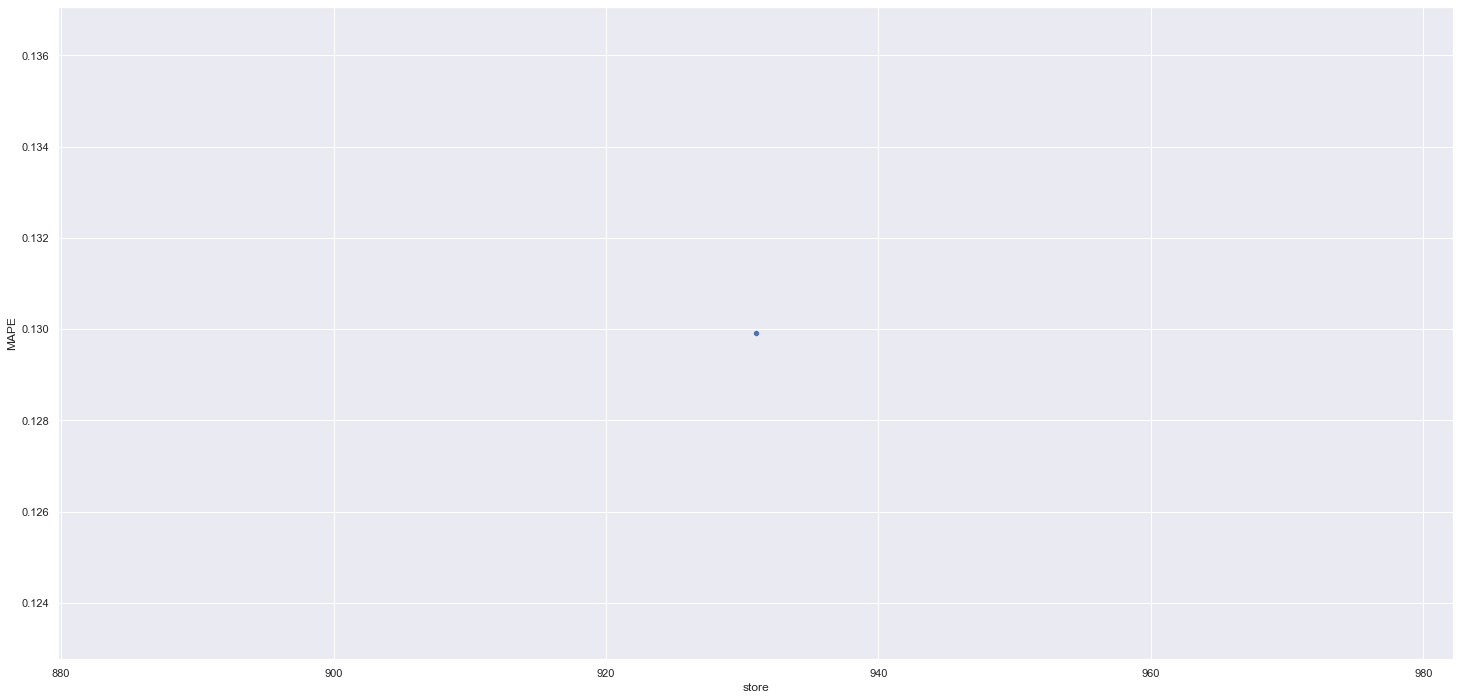

In [95]:
# scatterplot
sns.scatterplot(x = 'store', y = 'MAPE', data = df92 );

In [96]:
# 
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( ' {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"359,376.22"
1,worst_scenario,"358,920.77"
2,best_scenario,"359,831.67"


In [97]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

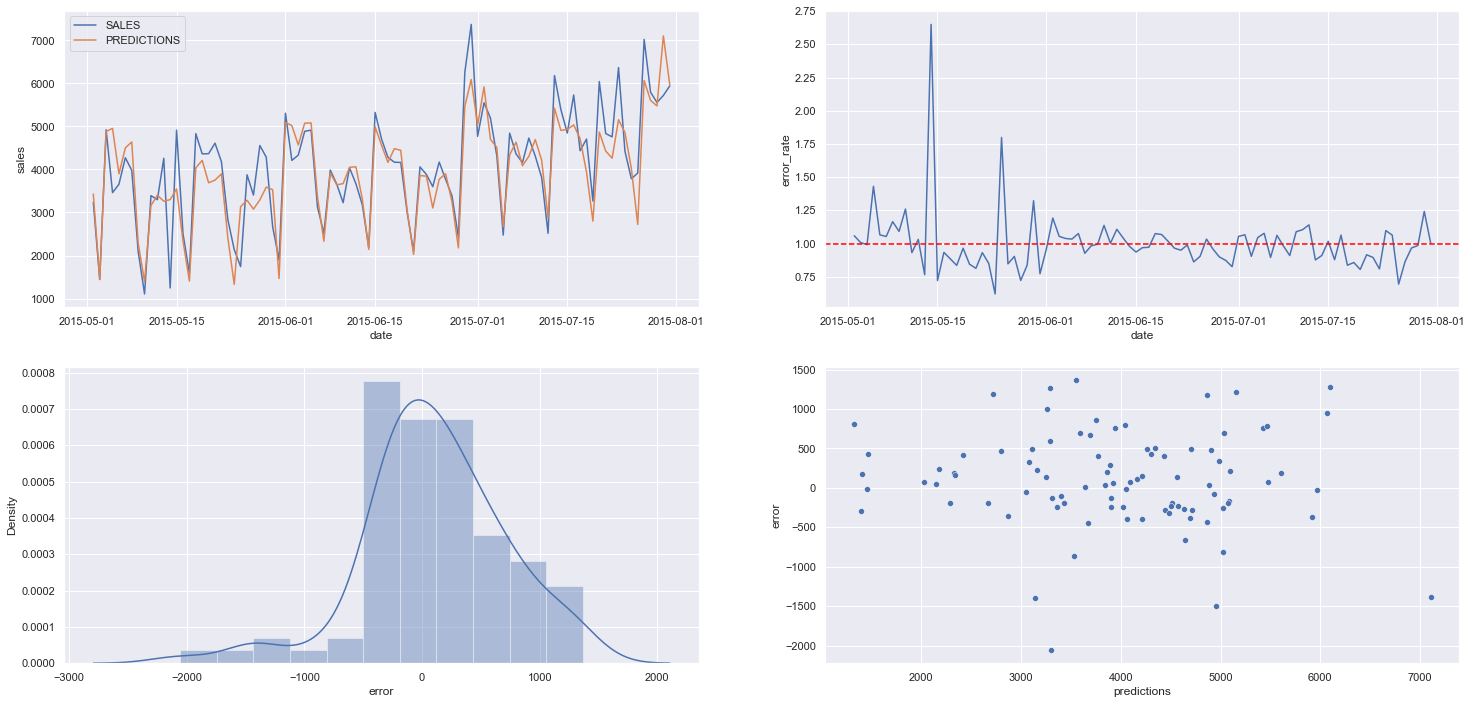

In [98]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--', color = 'red')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )